# Merge onecodex tax to graftM rhodopsin contigs

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## load graftM classification

In [3]:
graftm_mic = pd.read_csv("./data/graftm_tsv/MIC_nr_read_tax.tsv", sep="\t", names=["orf", "rhod_classification"])

In [4]:
graftm_mic["tara"] = "MIC"

In [5]:
graftm_vir = pd.read_csv("./data/graftm_tsv/VIR_nr_read_tax.tsv", sep="\t", names=["orf", "rhod_classification"])

In [6]:
graftm_vir["tara"] = "VIR"

In [7]:
graftm = pd.concat([graftm_mic, graftm_vir])

In [8]:
graftm["contig"] = graftm["orf"].apply(lambda x: "_".join(x.split("_")[:2]))

In [9]:
def clean_classification(x):
    try:
        rhod_type = x.split(";")[1]
        rhod_type = rhod_type.replace("k__","").strip()
        return rhod_type
    except IndexError:
        return "Unclassified"
        

In [10]:
graftm["rhod_classification"] = graftm["rhod_classification"].apply(clean_classification)

In [11]:
graftm.to_csv('./results/contig_rhod_classification.tsv', sep='\t', index=False)

## load onecodex classifications

To add the taxid names we need to:

1. replace the `Passed Filter` T values with C (the reads classified in kaiju are marked as C)
2. rearrange the tsv file so the taxid variable is the 3rd column
3. ww add the tax names

`ncbi_tax` can be found in the folder: `/data/Pepe/bpepe/projects/rhodopsin_hunt/2018-05-01`

`zcat mic.contigs.fasta.results.tsv.gz > mic.tsv`

`awk -v OFS="\t" -F"\t" '{print $4,$3,$1,$2}' mic.tsv > mic.fake_kaiju.out`

`sed -i -e 's/^T/C/g' *.fake_kaiju.out`

`find . -name '*.fake_kaiju.out' | parallel 'addTaxonNames -t ../ncbi_tax/nodes.dmp -n ../ncbi_tax/names.dmp -i {} -o {.}_full_names.out -r superkingdom,phylum,order,class,family,genus,species'`

In [12]:
onecodex_mic = pd.read_csv("./data/onecodex/mic.fake_kaiju_full_names.out",\
                           sep="\t",\
                           names=["status", "seq_len", "taxid", "N hits","full_tax"],\
                          skiprows=1)

In [13]:
onecodex_mic.head()

,status,seq_len,taxid,N hits,full_tax
0,C,6465,561,3,Bacteria; Proteobacteria; Enterobacterales; Ga...
1,F,4976,1951730,16,NaN
2,C,12444,1696175,146,Bacteria; Proteobacteria; Pelagibacterales; Al...
3,C,4263,0,0,NaN
4,C,5475,1977865,87,Bacteria; Proteobacteria; Pelagibacterales; Al...


In [14]:
onecodex_vir = pd.read_csv("./data/onecodex/vir.fake_kaiju_full_names.out",\
                           sep="\t",\
                           names=["status", "seq_len", "taxid", "N hits","full_tax"],\
                          skiprows=1)

we need to create a fasta.tsv file to assing the onecodex classifications to it's corresponding contig

In [16]:
mic_tsv = pd.read_csv("./data/mic.contigs.tsv", sep="\t", names=["full_contig", "seq"])

In [17]:
onecodex_mic = pd.concat([mic_tsv, onecodex_mic], axis=1)

In [18]:
vir_tsv = pd.read_csv("./data/vir.contigs.tsv", sep="\t", names=["full_contig", "seq"])

In [19]:
onecodex_vir = pd.concat([vir_tsv, onecodex_vir], axis=1)

In [20]:
onecodex = pd.concat([onecodex_mic, onecodex_vir])

In [21]:
onecodex["contig"] = onecodex["full_contig"].apply(lambda x: x.split(" ")[0])

In [22]:
onecodex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 39
Data columns (total 8 columns):
full_contig    1296 non-null object
seq            1296 non-null object
status         1296 non-null object
seq_len        1296 non-null int64
taxid          1296 non-null int64
N hits         1296 non-null int64
full_tax       631 non-null object
contig         1296 non-null object
dtypes: int64(3), object(5)
memory usage: 91.1+ KB


In [23]:
def remove_whitespace_from_tax(x):
    if isinstance(x, str):
        x_fix = x.replace(' ;', ';')
        x_fix = x_fix.replace('; ', ';')
        return x_fix
    else:
        return x

In [24]:
onecodex['full_tax'] = onecodex['full_tax'].apply(remove_whitespace_from_tax)

In [25]:
onecodex.head()

,full_contig,seq,status,seq_len,taxid,N hits,full_tax,contig
0,SAMEA2621155_1031902 /station=TARA_072 /depth=...,GTTAATAAAGTCAGCTAAGTTATAAATTATATTCAATGCATTAGCA...,C,6465,561,3,Bacteria;Proteobacteria;Enterobacterales;Gamma...,SAMEA2621155_1031902
1,SAMEA2621155_1106243 /station=TARA_072 /depth=...,AGAAGATGGAGATATGGATGTATTTCGTAAAGTAAGAAAAGATTTT...,F,4976,1951730,16,NaN,SAMEA2621155_1106243
2,SAMEA2621155_1668496 /station=TARA_072 /depth=...,CAAAGAGTTGGTTTAGCTAGAGCGCTAGCGGCCGATCCAGAGTTTT...,C,12444,1696175,146,Bacteria;Proteobacteria;Pelagibacterales;Alpha...,SAMEA2621155_1668496
3,SAMEA2621155_2100246 /station=TARA_072 /depth=...,ATCAGCATGCTTTGGGAAATTTTCCAAGTGAGCATTGTATGCTTCC...,C,4263,0,0,NaN,SAMEA2621155_2100246
4,SAMEA2621155_2236281 /station=TARA_072 /depth=...,ATTTAAATTTTCTCTTATTTTTTGAATAAGTTTTAAAATATTTTCT...,C,5475,1977865,87,Bacteria;Proteobacteria;Pelagibacterales;Alpha...,SAMEA2621155_2236281


## merge DFs

In [26]:
df = onecodex.merge(graftm, on="contig", how="left")

In [27]:
df['superkingdom'], df['phylum'], df['order'], \
df['class'], df['family'], df['genus'], df['species'] = df["full_tax"].str.split(';', 6).str
#df["full_tax"].str.split(';', 6, expand=True)

In [28]:
len(df)

1305

In [29]:
df.head()

,full_contig,seq,status,seq_len,taxid,N hits,full_tax,contig,orf,rhod_classification,tara,superkingdom,phylum,order,class,family,genus,species
0,SAMEA2621155_1031902 /station=TARA_072 /depth=...,GTTAATAAAGTCAGCTAAGTTATAAATTATATTCAATGCATTAGCA...,C,6465,561,3,Bacteria;Proteobacteria;Enterobacterales;Gamma...,SAMEA2621155_1031902,SAMEA2621155_1031902_1,type_1,MIC,Bacteria,Proteobacteria,Enterobacterales,Gammaproteobacteria,Enterobacteriaceae,Escherichia,NA;
1,SAMEA2621155_1106243 /station=TARA_072 /depth=...,AGAAGATGGAGATATGGATGTATTTCGTAAAGTAAGAAAAGATTTT...,F,4976,1951730,16,NaN,SAMEA2621155_1106243,SAMEA2621155_1106243_7,type_1,MIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SAMEA2621155_1668496 /station=TARA_072 /depth=...,CAAAGAGTTGGTTTAGCTAGAGCGCTAGCGGCCGATCCAGAGTTTT...,C,12444,1696175,146,Bacteria;Proteobacteria;Pelagibacterales;Alpha...,SAMEA2621155_1668496,SAMEA2621155_1668496_8,type_1,MIC,Bacteria,Proteobacteria,Pelagibacterales,Alphaproteobacteria,Pelagibacteraceae,NA,Pelagibacteraceae bacterium GOM-A3;
3,SAMEA2621155_2100246 /station=TARA_072 /depth=...,ATCAGCATGCTTTGGGAAATTTTCCAAGTGAGCATTGTATGCTTCC...,C,4263,0,0,NaN,SAMEA2621155_2100246,SAMEA2621155_2100246_2,helio,MIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SAMEA2621155_2236281 /station=TARA_072 /depth=...,ATTTAAATTTTCTCTTATTTTTTGAATAAGTTTTAAAATATTTTCT...,C,5475,1977865,87,Bacteria;Proteobacteria;Pelagibacterales;Alpha...,SAMEA2621155_2236281,SAMEA2621155_2236281_4,type_1,MIC,Bacteria,Proteobacteria,Pelagibacterales,Alphaproteobacteria,Pelagibacteraceae,Candidatus Pelagibacter,Candidatus Pelagibacter sp. RS40;


In [30]:
df.to_csv("./results/contig_rhod_onecodex_tax.tsv", sep="\t", index=False)

In [31]:
df = df.loc[df["rhod_classification"] != "Unclassified"]

In [32]:
len(df)

1272

In [33]:
sns.set_style("whitegrid")

---

# classification plot

In [34]:
contigs_classification_df = df[["rhod_classification", "full_tax"]].copy()

In [35]:
contigs_classification_df.loc[:,"tax_classification"] = contigs_classification_df["full_tax"].isnull().values

In [36]:
contigs_classification_df.loc[:, "tax_classification"] = \
contigs_classification_df["tax_classification"].replace(False,"Unclassified").replace(True,"Classified")

In [37]:
contigs_classification = contigs_classification_df.\
groupby(["rhod_classification", "tax_classification"]).agg(len)

In [38]:
contigs_classification.reset_index(inplace=True)

In [39]:
contigs_classification.rename(columns={"full_tax":"count"}, inplace=True)

In [40]:
contigs_classification.head()

,rhod_classification,tax_classification,count
0,helio,Classified,156
1,helio,Unclassified,56
2,type_1,Classified,487
3,type_1,Unclassified,573


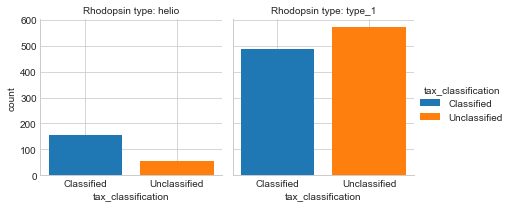

In [41]:
g = sns.FacetGrid(data=contigs_classification, col="rhod_classification", hue="tax_classification")
g = (g.map(plt.bar, "tax_classification", "count").add_legend())
g = (g.set_titles("Rhodopsin type: {col_name}"))

---
# per kingdom

In [42]:
classified = df.loc[~df["full_tax"].isnull()]

In [43]:
classification_kingdom = classified[["rhod_classification", "superkingdom","full_tax"]].copy()

In [44]:
classification_kingdom = classification_kingdom.\
groupby(["rhod_classification", "superkingdom"]).agg(len)

In [45]:
classification_kingdom.reset_index(inplace=True)

In [46]:
classification_kingdom.head()

,rhod_classification,superkingdom,full_tax
0,helio,Archaea,3
1,helio,Bacteria,44
2,helio,Eukaryota,3
3,helio,NA,3
4,helio,Viruses,3


In [47]:
classification_kingdom.rename(columns={"full_tax":"count"}, inplace=True)

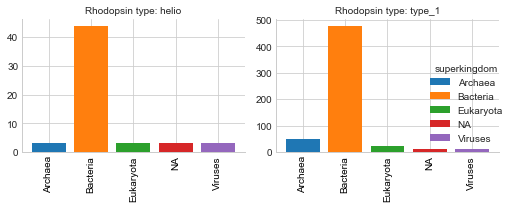

In [48]:
g = sns.FacetGrid(data=classification_kingdom, \
                  col="rhod_classification", \
                  hue="superkingdom", \
                  sharex=False, sharey=False)
g = (g.map(plt.bar, "superkingdom", "count").add_legend())
g = (g.map(plt.xticks, rotation=90, color="black"))
g = (g.set_titles("Rhodopsin type: {col_name}"))

---
# per phylum

In [49]:
classification_phylum = classified[["rhod_classification", "superkingdom","phylum"]].copy()

In [50]:
# add "virus" phylum
classification_phylum.loc[classification_phylum.superkingdom == 'Viruses', 'phylum'] = "Viruses"
# add euks
classification_phylum.loc[classification_phylum.superkingdom == 'Eukaryota', 'phylum'] = "Eukaryotes"

In [51]:
#classification_phylum = classified[["rhod_classification", "phylum","full_tax"]].copy()

In [52]:
classification_phylum = classification_phylum.\
groupby(["rhod_classification", "phylum"]).agg(len)

In [53]:
classification_phylum.reset_index(inplace=True)

In [54]:
classification_phylum.rename(columns={"superkingdom":"count"}, inplace=True)

In [55]:
rhodopsin_phylum_count = classification_phylum.groupby('rhod_classification').agg(sum)

In [56]:
rhodopsin_phylum_count

,count
rhod_classification,
helio,56
type_1,573


In [57]:
classification_phylum['phylum'] = classification_phylum['phylum'].replace('Candidatus Heimdallarchaeota', 'Asgard')

In [58]:
classification_phylum['phylum'] = classification_phylum['phylum'].replace('Candidatus Marinimicrobia', 'Candidatus\nMarinimicrobia')

In [59]:
taxa = classification_phylum.phylum.unique()

In [60]:
taxa

array(['Actinobacteria', 'Bacteroidetes', 'Asgard', 'Chloroflexi',
       'Cyanobacteria', 'Eukaryotes', 'NA', 'Proteobacteria',
       'Verrucomicrobia', 'Viruses', 'Balneolaeota',
       'Candidatus\nMarinimicrobia', 'Euryarchaeota', 'Firmicutes',
       'Planctomycetes', 'Rhodothermaeota', 'Tenericutes',
       'Thaumarchaeota'], dtype=object)

In [61]:
# add missing taxa
for rhod_type in ['helio', 'type_1']:
    for tax in taxa:
        if tax not in classification_phylum[(classification_phylum.rhod_classification == rhod_type)]['phylum'].unique():
            classification_phylum = classification_phylum.append({'rhod_classification':rhod_type, 'phylum':tax, 'count':0}, ignore_index=True)
classification_phylum.sort_values(by='phylum', inplace=True)

Calculate percentage

In [62]:
classification_phylum.loc[classification_phylum['rhod_classification'] == 'helio', '%'] = \
classification_phylum.loc[classification_phylum['rhod_classification'] == 'helio', 'count']*100/rhodopsin_phylum_count.loc['helio','count']

In [63]:
classification_phylum.loc[classification_phylum['rhod_classification'] == 'type_1', '%'] = \
classification_phylum.loc[classification_phylum['rhod_classification'] == 'type_1', 'count']*100/rhodopsin_phylum_count.loc['type_1','count']

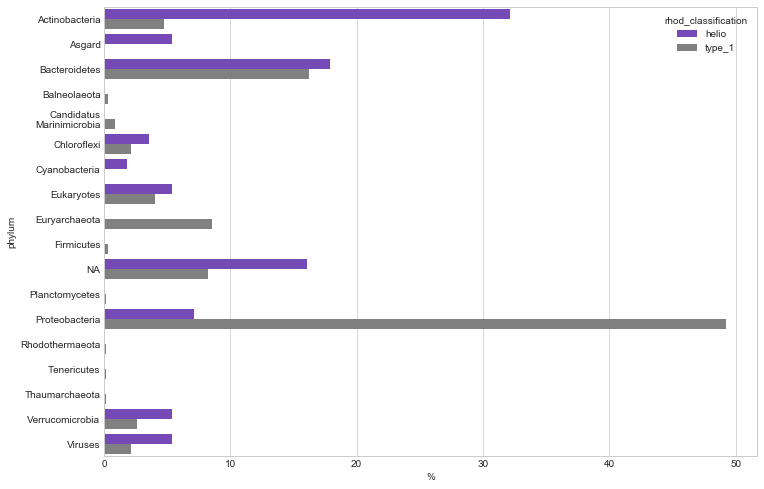

In [64]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

color_dict = {'helio':"#7137c8", 'type_1':"gray"}

g = sns.barplot(data=classification_phylum, x="%", y="phylum", hue="rhod_classification", ax=ax, palette=color_dict)
#for item in g.get_xticklabels():
#    item.set_rotation(90)

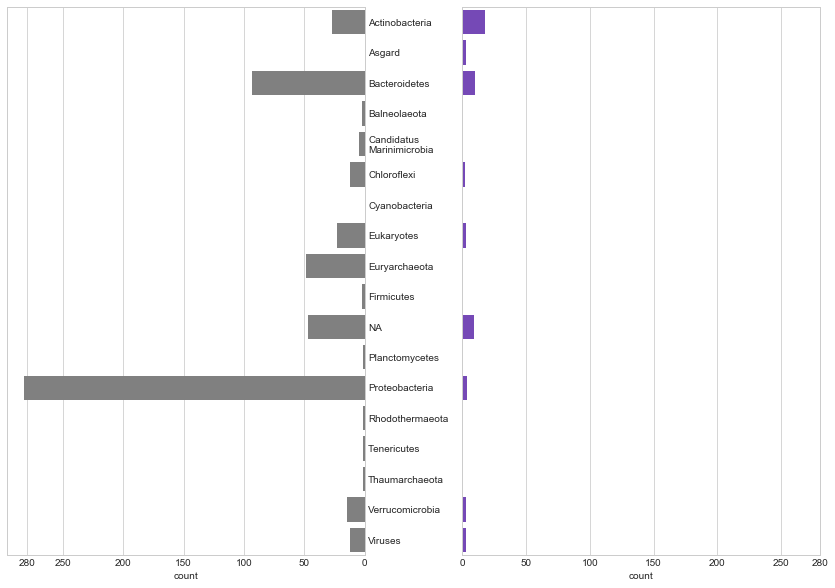

In [66]:
a4_dims = (11.7, 8.27)

color_dict = {'helio':"#7137c8", 'type_1':"gray"}

#to allow space between the helio and type_1 plots we create a 3 column design
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=a4_dims, sharex=False)

#barchart for type_1
sns.barplot(x="count", y="phylum", hue="rhod_classification", ax=axes[0], palette=color_dict, \
            data=classification_phylum[(classification_phylum.rhod_classification == 'type_1')])

#barchart for helio
sns.barplot(x="count", y="phylum", hue="rhod_classification", ax=axes[1], palette=color_dict, \
            data=classification_phylum[(classification_phylum.rhod_classification == 'helio')])

#flip left axis
axes[0].invert_xaxis()

#move the phylum
axes[0].yaxis.tick_right()

#remove legends
axes[0].legend_.remove()
axes[1].legend_.remove()

#remove axis titles
#axes[0].set_xlabel('')
axes[0].set_ylabel('')
#axes[1].set_xlabel('')
axes[1].set_ylabel('')

#fix x axis ticks
axes[0].set_xticks([0,50,100,150,200,250,280])
axes[1].set_xticks([0,50,100,150,200,250,280])

#
#axes[1].set_yticks(classification_phylum['phylum'].unique())
#axes[1].set_xticklabels(['0%','20%','40%'])

#close the gap between subplots
plt.tight_layout()

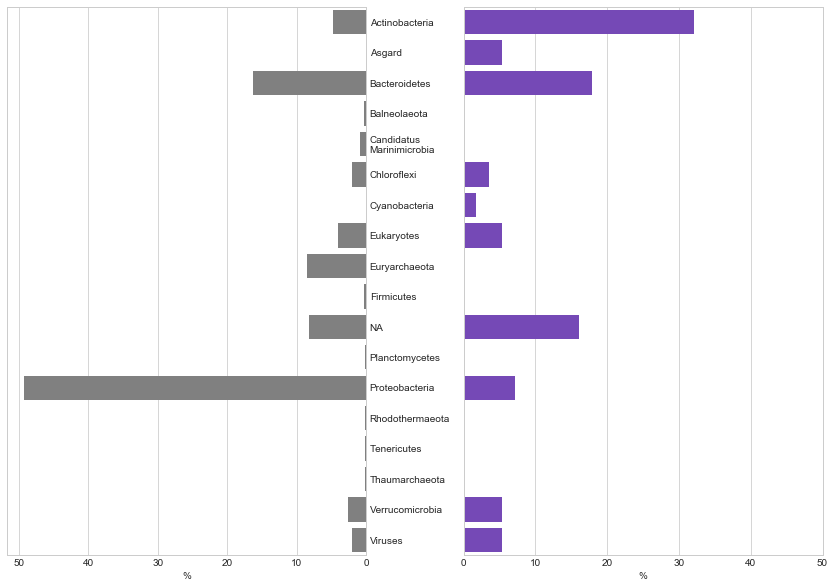

In [67]:
a4_dims = (11.7, 8.27)

color_dict = {'helio':"#7137c8", 'type_1':"gray"}

#to allow space between the helio and type_1 plots we create a 3 column design
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=a4_dims, sharex=False)

#barchart for type_1
sns.barplot(x="%", y="phylum", hue="rhod_classification", ax=axes[0], palette=color_dict, \
            data=classification_phylum[(classification_phylum.rhod_classification == 'type_1')])

#barchart for helio
sns.barplot(x="%", y="phylum", hue="rhod_classification", ax=axes[1], palette=color_dict, \
            data=classification_phylum[(classification_phylum.rhod_classification == 'helio')])

#flip left axis
axes[0].invert_xaxis()

#move the phylum
axes[0].yaxis.tick_right()

#center phylum



#remove legends
axes[0].legend_.remove()
axes[1].legend_.remove()

#remove axis titles
#axes[0].set_xlabel('')
axes[0].set_ylabel('')
#axes[1].set_xlabel('')
axes[1].set_ylabel('')

#fix x axis ticks
axes[0].set_xticks([0,10,20,30,40,50])
axes[1].set_xticks([0,10,20,30,40,50])

#
#axes[1].set_yticks(classification_phylum['phylum'].unique())
#axes[1].set_xticklabels(['0%','20%','40%'])

#close the gap between subplots
plt.tight_layout()

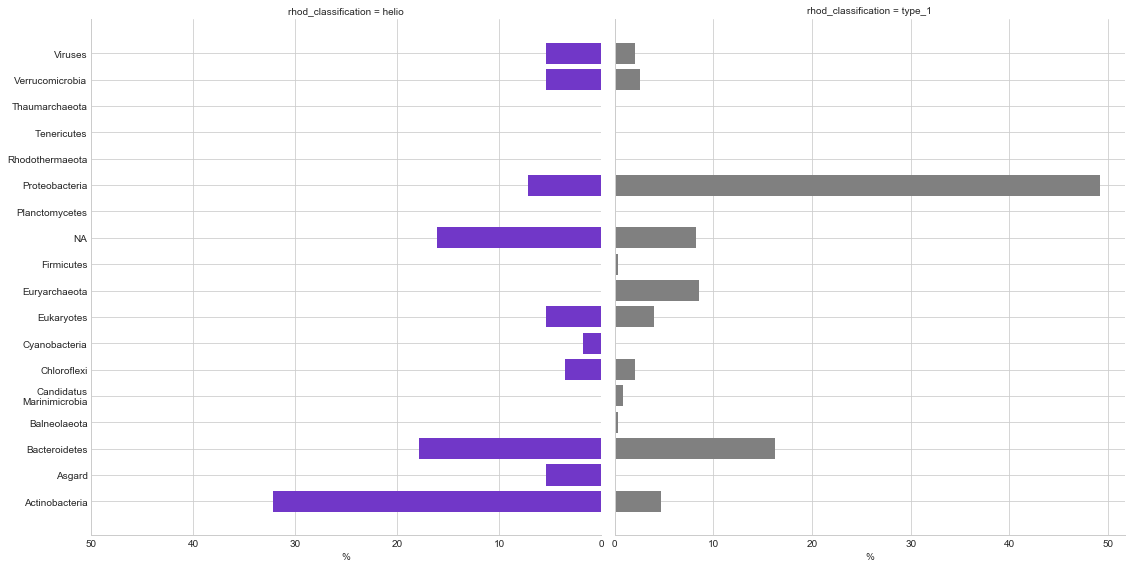

In [68]:
g = sns.FacetGrid(data=classification_phylum, \
                  col="rhod_classification", \
                  hue="rhod_classification", \
                  sharex=False, sharey=True, size=8, palette=color_dict)
g = (g.map(plt.barh, "phylum", "%"))

# axis containers
helio_ax = g.axes[0][0]
type1_ax = g.axes[0][1]

# invert x axis on helios
helio_ax.invert_xaxis()

# set x axis ticks
helio_ax.set_xticks([0,10,20,30,40,50]);

helio_ax.set_ylabel('')
helio_ax.set_xlabel('%');
type1_ax.set_xlabel('%');


#type1_ax.set_yticklabels(helio_ax.get_yticklabels())

#g = (g.map(plt.xticks, rotation=90, color="black"))
#g = (g.set_titles("Rhodopsin type: {col_name}"))